In [21]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction

import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         #learning_rate = "adaptive",
                         tol=1e-20) #default tolerance
    model.fit(X_train, y_train)
    return model

In [23]:
past_weeks = 3
hidden_layers = (2,1)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('forecast1.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [24]:
df['residuals'].size

12902

In [25]:
def data_ANN(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [26]:
X, y = data_ANN(past_weeks, df)

100%|██████████| 12398/12398 [00:00<00:00, 27178.36it/s]


In [27]:
train_size_percentage = 0.50

train_size = int(len(X)*train_size_percentage)
#print(len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number))/(24*7))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [28]:
model = ANN_train(X_train, y_train, hidden_layers)

In [29]:
def ANN_pred(model, X_test,X,y):
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        X_test_el = X_test[i].values
        val = model.predict(X_test_el.reshape(1,-1))
        y_test.append(val[0])
        #if i%24==0 and i!= len(X_test)-24:
        #    model = ANN_train(X[:train_size+i], y[:train_size+i],hidden_layers)
    return y_test



In [30]:
y_pred = ANN_pred(model, X_test,X,y)

100%|██████████| 6199/6199 [00:00<00:00, 8453.77it/s]


In [31]:
temp = df.copy()
temp['pred_residuals'] = np.nan
temp['pred_residuals'].iloc[-len(y_pred):] = y_pred
#(temp['residuals']-temp['pred_residuals']).dropna().hist()

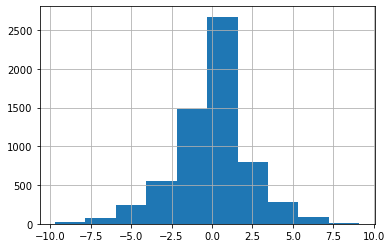

In [32]:
temp["pred_residuals"].hist()

In [33]:
df_from_ANN = pd.read_pickle('ANN_forecast.pkl')

In [34]:
df_from_ANN

,grid1-loss,pred,diff,ann_sum_error,ann_cumsum
2019-12-01 00:00:00,21.55210,22.686309,-1.134209,1.134209,1.134209
2019-12-01 01:00:00,20.71190,21.595508,-0.883608,0.883608,2.017817
2019-12-01 02:00:00,20.27340,20.773316,-0.499916,0.499916,2.517733
2019-12-01 03:00:00,20.25370,20.443139,-0.189439,0.189439,2.707172
2019-12-01 04:00:00,20.40550,20.209076,0.196424,0.196424,2.903596
...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,13.035968,-4.476168,4.476168,22534.680531
2020-05-30 20:00:00,6.95209,12.870605,-5.918515,5.918515,22540.599047
2020-05-30 21:00:00,8.11558,12.926121,-4.810541,4.810541,22545.409588
2020-05-30 23:00:00,7.26431,12.561953,-5.297643,5.297643,22550.707231


In [35]:
temp = temp.dropna()

temp['Hybrid'] = temp['ARIMA']+temp['pred_residuals']
temp['ANN'] = df_from_ANN['pred']

temp['arima_sum_error'] = abs(temp['grid-loss'] - temp['ARIMA'])
temp['hybrid_sum_error'] = abs(temp['grid-loss'] - temp['Hybrid'])
temp['ann_sum_error'] = df_from_ANN['ann_sum_error']

temp['arima_cumsum'] = temp['arima_sum_error'].cumsum()
temp['hybrid_cumsum'] = temp['hybrid_sum_error'].cumsum()
temp['error_in_res'] = (temp['residuals']-temp['pred_residuals'])
temp['ann_cumsum'] = df_from_ANN['ann_sum_error'].iloc[-train_size:].cumsum()

In [36]:
temp['ANN']

2019-09-14 08:00:00          NaN
2019-09-14 09:00:00          NaN
2019-09-14 10:00:00          NaN
2019-09-14 11:00:00          NaN
2019-09-14 12:00:00          NaN
                         ...    
2020-05-30 19:00:00    13.035968
2020-05-30 20:00:00    12.870605
2020-05-30 21:00:00    12.926121
2020-05-30 23:00:00    12.561953
2020-05-31 00:00:00    12.481584
Name: ANN, Length: 6199, dtype: float64

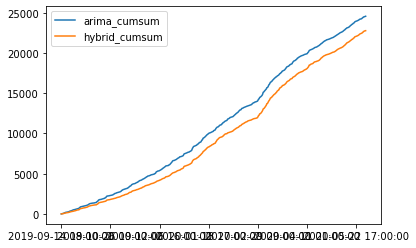

In [37]:
temp[['arima_cumsum','hybrid_cumsum']].plot()


In [38]:
(temp['arima_cumsum'].iloc[-1]-temp['hybrid_cumsum'].iloc[-1])/temp['arima_cumsum'].iloc[-1]

0.07313081496126014

<Figure size 432x288 with 0 Axes>

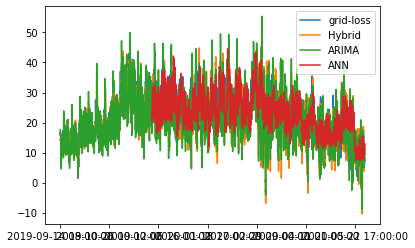

In [39]:
fig = plt.figure()
plt = temp[['grid-loss','Hybrid','ARIMA', 'ANN']].plot()
#plt.xlabel("hei", fontsize = 18)


In [40]:
diff = temp['grid-loss']-temp['Hybrid']
mse_hybrid = (diff**2).mean()

In [41]:
diff = temp['grid-loss']-temp['ARIMA']
mse_arima = (diff**2).mean()



In [42]:
(mse_arima-mse_hybrid)/mse_arima

0.11976736826257496

In [43]:
abs(temp['error_in_res']).cumsum()

2019-09-14 08:00:00        2.071228
2019-09-14 09:00:00        3.379316
2019-09-14 10:00:00        4.636791
2019-09-14 11:00:00        6.311599
2019-09-14 12:00:00        8.308354
                           ...     
2020-05-30 19:00:00    22771.315665
2020-05-30 20:00:00    22771.364084
2020-05-30 21:00:00    22771.460638
2020-05-30 23:00:00    22777.186542
2020-05-31 00:00:00    22779.886723
Name: error_in_res, Length: 6199, dtype: float64

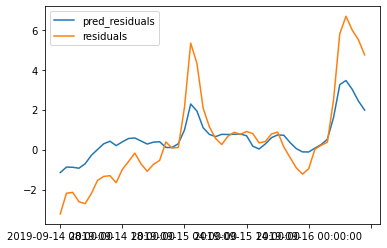

In [44]:
temp[['pred_residuals','residuals']].iloc[:50].plot()

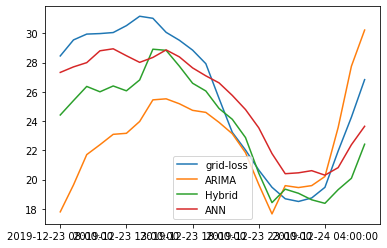

In [45]:
temp[['grid-loss','ARIMA', 'Hybrid', 'ANN']].iloc[2400:2424].plot()

In [46]:
mse = sum([temp['grid-loss']-temp['Hybrid']])